In [ ]:
from nltk import ngrams
import pandas as pd
import string
import spacy
import nltk
from nltk.corpus import stopwords
import re
import numpy as np
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from sklearn.pipeline import Pipeline
import joblib
import gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim.models import CoherenceModel
from gensim.models import Word2Vec
import gensim.downloader
from scipy import spatial

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 6.0 MB/s eta 0:00:00


### Costanti

In [ ]:
URL_DATASET = 'https://raw.githubusercontent.com/ProfAI/natural-language-processing/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv'
PATH_DRIVE = '/content/drive/MyDrive/MASTER DATA SCIENCE/8 - NLP/Progetto Filtro Anti Spam/'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Funzioni

In [ ]:
nlp = spacy.load('en_core_web_sm')
eng_stopwords = stopwords.words('english')
punctuation = set(string.punctuation)
re_html = re.compile('<.*?>')

def data_cleaner(sentence):

  sentence = sentence.lower()

  for c in punctuation:
    sentence = sentence.replace(c, ' ')

  document = nlp(sentence)

  sentence = " ".join(token.lemma_ for token in document)
  sentence = " ".join(word for word in sentence.split() if word not in eng_stopwords)
  #sentence = re.sub('\d','',sentence)
  sentence = re.sub('\s',' ',sentence)
  sentence = re.sub(re_html,' ',sentence)
  sentence = re.sub(' +',' ',sentence)

  return sentence


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:18: DeprecationWarning: invalid escape sequence '\s'
<>:18: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-5-0999e1c8a151>:18: DeprecationWarning: invalid escape sequence '\s'
  sentence = re.sub('\s',' ',sentence)


In [ ]:
def plot_confusion_matrix(y_true, y_predict, labels = ['0','1']):

  #function to plot confusion matrix
  #labels: labels of the target

  cm = confusion_matrix(y_true, y_predict)

  df_cm = pd.DataFrame(cm,
                      index = [labels[0],labels[1]],
                      columns = ['Predicted '+labels[0], 'Predicted '+labels[1]])

  plt.figure()
  sns.heatmap(df_cm, annot = True, fmt = 'g')
  plt.title('CONFUSION MATRIX')
  plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def avg_vector(sentence):


  word_nodict = 0
  for word in sentence:
    if word in glove_vector.key_to_index.keys():
      if "vector" not in locals():
        vector = glove_vector.get_vector(word).reshape(300,1)
      else:
        vector = np.concatenate([vector, glove_vector.get_vector(word).reshape(300,1)], axis = 1)
    else:
      word_nodict +=1

  if word_nodict == len(sentence):
    return np.zeros(300)
  else:
    return vector.mean(axis = 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###Caricamento ed esplorazione del dataset

In [ ]:
df = pd.read_csv(URL_DATASET)

In [ ]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


In [ ]:
df = df[['text', 'label_num']]

In [ ]:
df.head()

,text,label_num
0,Subject: enron methanol ; meter # : 988291\nth...,0
1,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\nthis deal is to ...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5171 non-null   object
 1   label_num  5171 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 80.9+ KB


Il dataset è composto da 5171 osservazioni, tutte non nulle. Sono state considerate e quindi conservate le colonne *text* e *label_num* che contengono rispettivamente il testo e la label codificata (0: ham, 1: spam)

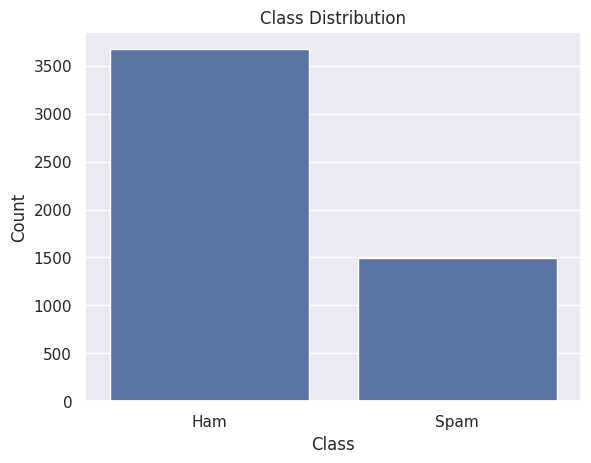

In [ ]:
plt.figure()
sns.set_theme()
sns.countplot(data = df, x = 'label_num')
plt.xticks([0,1],['Ham', 'Spam'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [ ]:
df.label_num.value_counts(normalize = True)

label_num
0    0.710114
1    0.289886
Name: proportion, dtype: float64

Si nota che il 71% delle osservazioni appartiene alla classe ham quindi il dataset non è bilanciato. Tale aspetto andrà considerato nella valutazione del modello di classificazione.

### Preprocessing - Data Cleaning

La pulizia del dataset è stata eseguita implementando la funzione *data_cleaner* che:


*   Converte evetuali maiuscole in minuscole
*   Elimina i caratteri di punteggiatura
*   Esegue la lemmatizzazione
*   Elimina le stopwords
*   Elimina caratteri speciali di tabulazione
*   Elimina tag HTML
*   Elimina spazi superflui



In [ ]:
df.text[0]

"Subject: enron methanol ; meter # : 988291\nthis is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary\nflow data provided by daren } .\nplease override pop ' s daily volume { presently zero } to reflect daily\nactivity you can obtain from gas control .\nthis change is needed asap for economics purposes ."

In [ ]:
data_cleaner(df.text[0])

'subject enron methanol meter 988291 follow note I give monday 4 3 00 preliminary flow datum provide daren please override pop daily volume presently zero reflect daily activity obtain gas control change need asap economic purpose'

In [ ]:
df['text'] = df['text'].apply(data_cleaner)

In [ ]:
index = np.random.choice(df.shape[0], 5)

for i in index:
  print(df['text'][i])
  print('\n'+' - '*10+'\n')

subject new cial softtab save 80 discount drug save 80 every order number one online retailler dozen medication customer save 80 cent every dollar every time compare industry price yes less quarter price product customer ask include new superviagra soft tab work 15 minute next generation sexual improvement wonder drug far effective viagra half pill last 36 hour get information superviagra http cordone net cs cheapgeneric key keep customer satisfied easy order online save 80 regular price massive stock drug day dispatch fast delivery straight door discrete packaging big internet retailler thousand regular customer consultation fee intimate question examination appointment prior prescription need private confidential service please come shop see massive range product available low price huge stock ready day dispatch two million customer wrong see full range http cordone net cheapgeneric

 -  -  -  -  -  -  -  -  -  - 

subject harassment avoidance clarification clarification harassment p

In [ ]:
df.to_csv(PATH_DRIVE+'df_cleaned.csv')

### Modello

Il dataset è stato suddiviso in Training, Validation e Test Set.

In [ ]:
X = df.text.values
y = df.label_num.values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state = 0)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.1/0.9, random_state = 0)

In [ ]:
 X_train.shape, X_test.shape, X_val.shape

((4136, 40213), (518, 40213), (517, 40213))

In [ ]:
 y_train.shape, y_test.shape, y_val.shape

((4136,), (518,), (517,))

#### Naive-Bayes

Si è deciso di optare per un classificatore di tipo Naive-Bayes in quanto si tratta di modelli computazionalmente vantaggiosi da addestrare e particolarmente diffusi in quest'ambito. In particolare, si sono testati due tipi di modelli basati sul Teorema di Bayes: il Multinomial Naive-Bayes e il Complement Naive-Bayes, quest'ultimo risulta particolarmente adatto per dataset sbilanciati.

I due modelli sono stati addestrati sul Training Set e valutati sul Validation Set.

Prima di procedere con il fit del modello il corpus di testo è stato vettorizzato utilizzando il metodo Bag of Words (BOW), esso non è sicuramente il metodo di vettorizzazione più efficiente tuttavia è adatto per i modelli Naive-Bayes.

In [ ]:
bow_vect = CountVectorizer()
X_train = bow_vect.fit_transform(X_train)
X_test = bow_vect.transform(X_test)
X_val = bow_vect.transform(X_val)
X_train = X_train.toarray()
X_test = X_test.toarray()
X_val = X_val.toarray()

In [ ]:
len(bow_vect.vocabulary_)

40213

In [ ]:
X_train.shape, X_test.shape

((4136, 40213), (518, 40213))

##### Multinomial Naive-Bayes

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

Classification Report - Training Set

In [ ]:
print(classification_report(y_train, mnb.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2931
           1       0.98      0.97      0.98      1205

    accuracy                           0.99      4136
   macro avg       0.98      0.98      0.98      4136
weighted avg       0.99      0.99      0.99      4136



Classification Report - Test Set

In [ ]:
print(classification_report(y_val, mnb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       372
           1       0.96      0.94      0.95       145

    accuracy                           0.97       517
   macro avg       0.97      0.96      0.97       517
weighted avg       0.97      0.97      0.97       517



Confrontando i risultati mostrati nel classification report tra Training e Validation Set si nota che non è presente overfitting. I risultati ottenuti in termini di accuratezza, precisione e recall sono soddisfacenti.

##### Complement Naive-Bayes

In [ ]:
cnb = ComplementNB()
cnb.fit(X_train, y_train)

ComplementNB()

In [ ]:
print(classification_report(y_train, cnb.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2931
           1       0.98      0.98      0.98      1205

    accuracy                           0.99      4136
   macro avg       0.98      0.98      0.98      4136
weighted avg       0.99      0.99      0.99      4136



In [ ]:
print(classification_report(y_val, cnb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       372
           1       0.95      0.95      0.95       145

    accuracy                           0.97       517
   macro avg       0.97      0.97      0.97       517
weighted avg       0.97      0.97      0.97       517



Anche in questo caso non è presente overfitting e le prestazioni sono soddisfacenti.

#### Scelta e valutazione del modello

Le prestazioni ottenute sul Validation Set dai due modelli realizzati sono pressochè identichè, tuttavia considerando che il dataset è sbilanciato si è deciso di utilizzare il modello Complement Naive-Bayes che è più adatto per questa situazione. E' stata creata e salvata per successivi utilizzi una pipeline che aggrega la vettorizzazione e il modello vero e proprio.

In [ ]:
model = Pipeline([('bow_vect', bow_vect),
                  ('cnb', cnb)])

In [ ]:
joblib.dump(model, PATH_DRIVE+'model_bow_cnb.joblib')

['/content/drive/MyDrive/MASTER DATA SCIENCE/8 - NLP/Progetto Filtro Anti Spam/model_bow_cnb.joblib']

In [ ]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       369
           1       0.95      0.94      0.94       149

    accuracy                           0.97       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.97      0.97      0.97       518



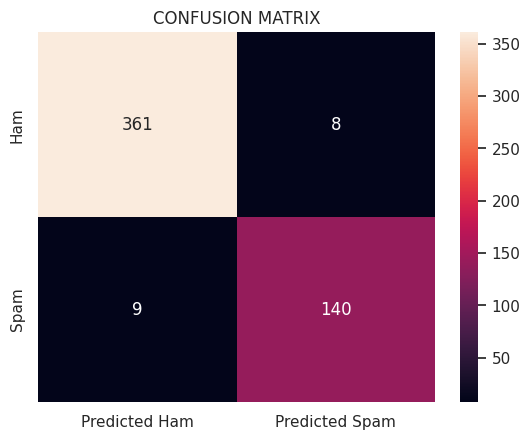

In [ ]:
plot_confusion_matrix(y_test, model.predict(X_test), labels=['Ham', 'Spam'])

Si nota che le prestazioni del modello mostrate sul Test Set sono in linea con quelle esibite sul Validation Set e quindi più che soddisfacenti in termini di accuratezza, precisione e recall. Dalla Confusion Matrix si osserva che il modello sbaglia la classificazione solo su 17 osservazioni su 518, equamente bilanciate tra Spam e Ham.

### Topic Modelling

Nella seguente sezione si è tentanto di individuare i principali topic tra le mail *SPAM*. A tal scopo è stato utilizzato l'algoritmo Latent Dirichlet Allocation (LDA).

In [ ]:
df = pd.read_csv(PATH_DRIVE+'df_cleaned.csv', index_col = 0)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,label_num
0,subject enron methanol meter 988291 follow not...,0
1,subject hpl nom january 9 2001 see attached fi...,0
2,subject neon retreat ho ho ho around wonderful...,0
3,subject photoshop window office cheap main tre...,1
4,subject indian spring deal book teco pvr reven...,0


In [ ]:
df_spam = df[df.label_num == 1]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1499 entries, 3 to 5170
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1499 non-null   object
 1   label_num  1499 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 35.1+ KB


In [ ]:
texts = [text.split() for  text in df_spam.text]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
id2word = gensim.corpora.Dictionary(texts)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
corpus = [id2word.doc2bow(text) for  text in texts]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Per individuare il numero ideale di topic in cui categorizzare le mail SPAM del dataset è stata valuatata la coerenza tra i topic del modello al variare del numero di topic, mantenendo costanti gli altri iperparametri.

La coerenza misura quanto le parole più rilevanti all'interno di ciascun topic siano semanticamente simili tra loro, si riesce così a distinguere tra modelli che propongono topic semanticamente interpretabili da modelli i cui topic sono frutto esclusivamente di inferenza statistica e che quindi non hanno un significato da noi interpretabile.

Bibliografia:

[Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)

[Evaluate Topic Models: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0)

In [ ]:
def get_coherence_topic(corpus, id2word, num_topics):
  model = gensim.models.LdaMulticore(corpus = corpus,
                                     id2word = id2word,
                                     num_topics = num_topics,
                                     passes = 10)

  coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')

  return coherence_model.get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ntopic_comp = {'n_topic':[],
               'cv':[]}

for i in range(2,11):
  coherence = get_coherence_topic(corpus, id2word, num_topics = i)

  ntopic_comp['n_topic'].append(i)
  ntopic_comp['cv'].append(coherence)

df_comp_ntopic = pd.DataFrame(ntopic_comp)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


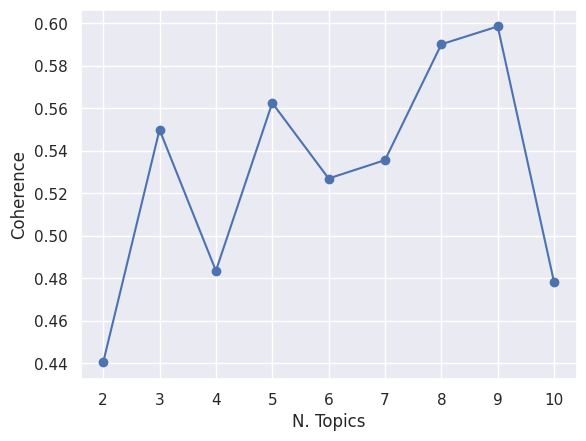

In [ ]:
sns.set_theme()
plt.plot(df_comp_ntopic.n_topic, df_comp_ntopic.cv, marker = 'o')
plt.xlabel('N. Topics')
plt.ylabel('Coherence')
plt.show()

Si nota che i valore massimo di coerenza si ottiene con 9 topics, si è quindi addestrato un modello LDA utilizzando tale valore per il parametro *num_topics*.

In [ ]:
num_topics = 9

lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word = id2word,
                                       num_topics = num_topics,
                                       passes = 10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for topic in lda_model.print_topics(num_words = 5):
  print(topic)

(0, '0.008*"company" + 0.004*"international" + 0.004*"000" + 0.004*"number" + 0.004*"subject"')
(1, '0.007*"adobe" + 0.006*"window" + 0.006*"95" + 0.005*"price" + 0.005*"xp"')
(2, '0.018*"subject" + 0.011*"http" + 0.010*"3" + 0.009*"com" + 0.008*"get"')
(3, '0.020*"td" + 0.016*"font" + 0.015*"http" + 0.015*"height" + 0.015*"0"')
(4, '0.028*"I" + 0.009*"subject" + 0.004*"get" + 0.004*"money" + 0.004*"good"')
(5, '0.015*"company" + 0.011*"statement" + 0.009*"stock" + 0.007*"information" + 0.006*"security"')
(6, '0.017*"nbsp" + 0.009*"I" + 0.007*"subject" + 0.006*"new" + 0.003*"get"')
(7, '0.010*"com" + 0.009*"computron" + 0.009*"I" + 0.008*"subject" + 0.006*"contact"')
(8, '0.034*"3" + 0.008*"color" + 0.008*"font" + 0.006*"face" + 0.006*"p"')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La libreria *pyLDAvis* è stata utilizzata per visualizzare il risultato ottenuto e condurre analisi su di esso.
Il grafico a sinistra mostra la distanza tra i topic proiettandoli sulle due componenti principali; sulla sinistra, selezionando uno specifico topic, sono mostrati le 30 parole più rilevanti per quel topic.

La rilevanza delle parole è calcolata utilizzando una nuovo metodo proposto dagli autori di tale libreria: esso considera sia la probabilità di ogni parola del corpus di testo di essere presente in un certo topic sia il suo peso nel corpus di testo. Il parametro *lambda* consente di dare più o meno peso a uno dei termini della formula, con *lambda* pari a 1 si considera esclusivamente la probabilità che una certa parola appartenga a un determinato topic. Gli autori hanno indicato come valore ottimale 0.6.


Bibliografia:

[pyLDAvis - Documentation](https://pyldavis.readthedocs.io/en/latest/readme.html#more-documentation)

In [ ]:
lda_display = gensimvis.prepare(lda_model, corpus, id2word, sort_topics=False)

pyLDAvis.display(lda_display)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In generale, si nota che i topic sono abbstanza distanti tra loro ad accezzione del 3,5 e 7 che sono molto sovrapposti e del 1 e il 6 che sono piuttosto vicini. Osservando le parole più rilevanti per ogni topic si possono individuare i macroargomenti che li caratterizzano. Ad esempio i topic 1 e 6 sembrano trattare di proposte di investimento nel mercato azionario e metodi di guadagno alternativi, il topic 5 riguarda proposte di acquisto di farmaci o integratori da uomo con particolare riferimento alla sfera sessuale. Dall'analisi delle parole più rilevanti dei topic 4 e 9 sembra che contengono informazioni relative a siti web.

Ad ogni mail *SPAM* del dataset è stato asseganto un topic, considerando quello con la probabilità di appartenza massima.

In [ ]:
topics = lda_model[corpus]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
doc_topics = []

for topic in topics:
  topic = np.array(topic)
  doc_topic = topic[np.argmax(topic[:,1]),0]
  doc_topics.append(int(doc_topic))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(doc_topics)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1499, (1499, 3))

In [ ]:
df_spam.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1499, 2)

In [ ]:
df_spam['topic'] = doc_topics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-882a1aa2c7a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spam['topic'] = doc_topics


In [ ]:
df_spam.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,label_num,topic
3,subject photoshop window office cheap main tre...,1,6
7,subject look medication good source difficult ...,1,2
10,subject vocable rnd word asceticism vcsc brand...,1,5
11,subject report 01405 wffur attion brom est ins...,1,7
13,subject vic odin n ow berne hotbox carnal brid...,1,0


In [ ]:
df_spam.to_csv(PATH_DRIVE+'df_spam_topic.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Distanza semantica tra i topic
Nella seguente sezione è stata calcolata la distanza semantica tra i topic. A tal scopo è stata utilizzato l'embedding, che consente di mappare ogni parola in uno spazio vettoriale in cui parole semanticamente simili saranno vicine. In particolare per ogni mail *SPAM* del corpus è stato calcolato l'embedding di ogni parola e poi la media per ciascun documento. Infine, è stato calcolato un valore medio per tutti documenti appartenenti a ogni topic.

In [ ]:
df_spam = pd.read_csv(PATH_DRIVE+'df_spam_topic.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_spam.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,label_num,topic
0,subject photoshop window office cheap main tre...,1,6
1,subject look medication good source difficult ...,1,2
2,subject vocable rnd word asceticism vcsc brand...,1,5
3,subject report 01405 wffur attion brom est ins...,1,7
4,subject vic odin n ow berne hotbox carnal brid...,1,0


In [ ]:
df_spam.topic.unique()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([6, 2, 5, 7, 0, 3, 4, 1, 8])

In [ ]:
glove_vector = gensim.downloader.load('glove-wiki-gigaword-300')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
df_spam.topic.value_counts()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


topic
2    612
4    258
6    124
7    115
5    110
0     95
1     73
3     71
8     41
Name: count, dtype: int64

In [ ]:
vect_topic = []

for i in range(9):
  vect_topic.append(np.array([avg_vector(text) for text in df_spam[df_spam.topic == i].text]).mean(axis = 0))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(vect_topic)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


9

In [ ]:
for i in range(len(vect_topic)): print(vect_topic[i].shape)

(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)
(300,)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


La distanza semantica tra i topic è stata calcolata utilizzando la *cosine distance*, questa sarà pari a 0 per parole identiche (vettori completamenti sovrapposti) e pari 1 quando la distanza semantica è massima (vettori perpendicolari).

In [ ]:
topic_distances = []

for i in range(len(vect_topic)):
  row=[]
  for j in range(len(vect_topic)):
    row.append(spatial.distance.cosine(vect_topic[i], vect_topic[j]))

  topic_distances.append(row)

topic_distances = np.array(topic_distances)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


I valori di distanza semantica tra i 9 topic sono stati riportati nella seguente heatmap, così da darne evidenza visiva. Ovviamente sarà una matrice simmetrica e con diagonale nulla (stesso topic).

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


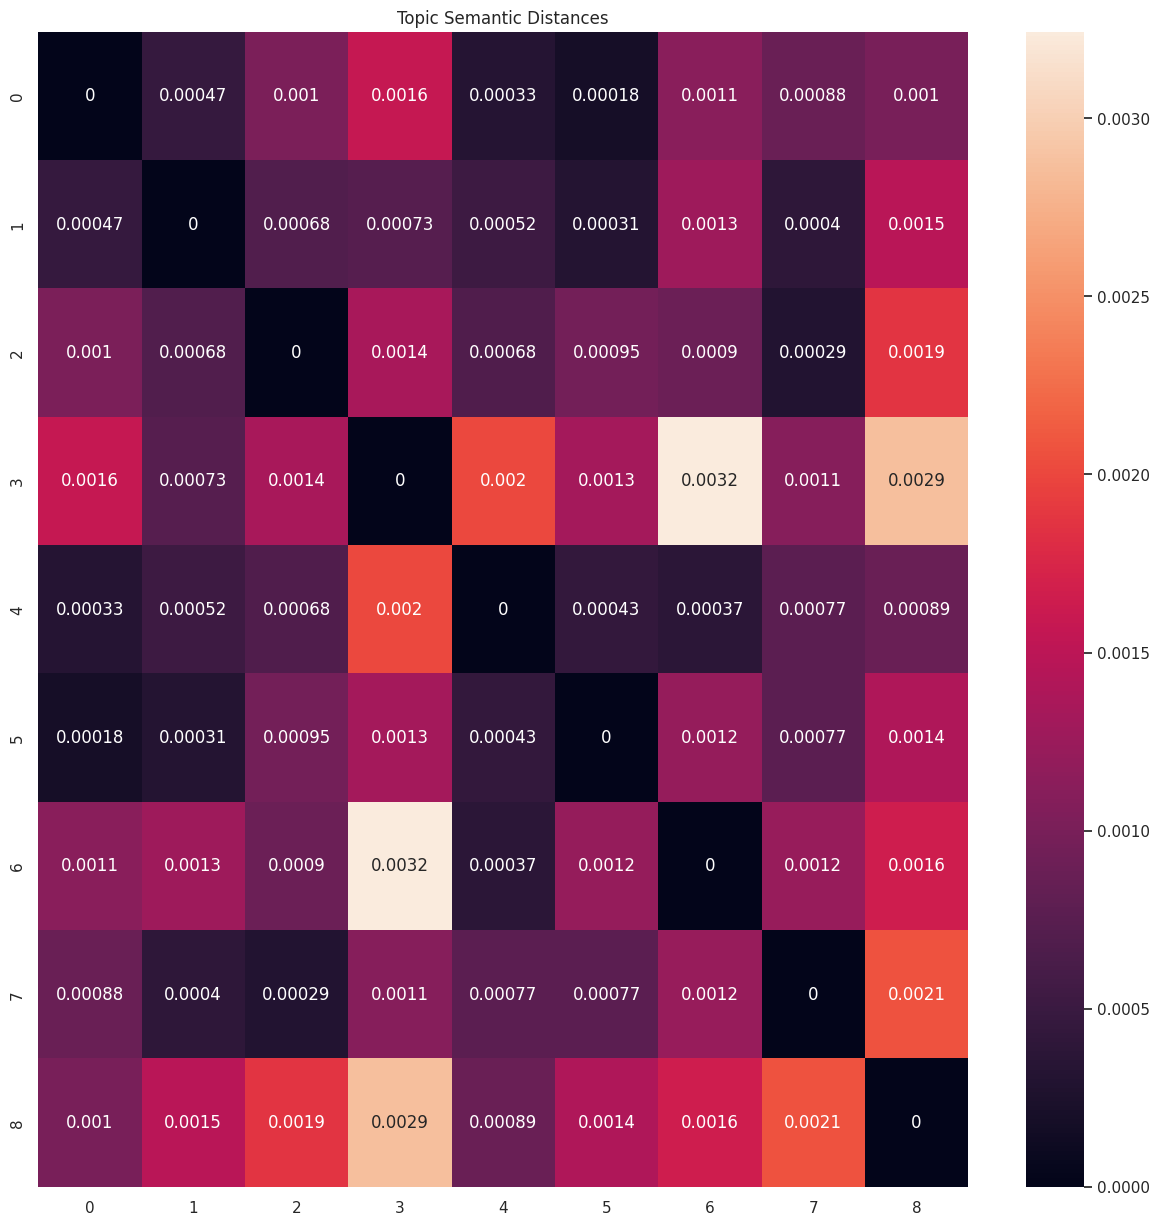

In [ ]:
plt.figure(figsize = (15,15))
sns.heatmap(topic_distances, annot = True)
plt.title('Topic Semantic Distances')
plt.show()

Si nota che le distanze semantiche tra i topic sono molto basse, questo potrebbe essere dovuto al fatto che si tratta comunque di mail *SPAM* con contenuto informativo simile.

### Estrazione delle organizzazioni presenti nelle mail NON SPAM
 Dalle mail *NON SPAM* del dataset sono state estratte tutte le organizzazioni presenti utilizzando una tecnica chiamata Name Entity Recognition (NER). In particolare, è stato utilizzato un modello pre-addestrato della libreria *spacy*.

In [ ]:
df = pd.read_csv(PATH_DRIVE + 'df_cleaned.csv', usecols = [1,2])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_ham= df[df.label_num == 0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_ham.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(3672, 2)

In [ ]:
nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
organizations = []

for text in df_ham.text:

  doc = nlp(text)

  for token in doc:

    if str(token.ent_type_) == 'ORG' and str(token) not in organizations:
      organizations.append(str(token))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
len(organizations)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1555

Nelle mail NON SPAM in totale sono presenti 1555 organizzazioni.

In [ ]:
organizations = pd.DataFrame(organizations)
organizations.to_csv(PATH_DRIVE+'organization_ham.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Di seguito sono riportate le prime 20 organizzazioni individuate nelle mail *NON SPAM*.

In [ ]:
print(organizations[:20])

              0
0          shop
1       antique
2        locker
3          kids
4          foot
5         store
6             u
7        canada
8   participate
9       program
10        jones
11        enron
12      tenaska
13        acton
14         corp
15      christy
16         mike
17       morris
18      subject
19           fw


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Conclusioni
Per la realizzazione del filtro anti spam, oggetto del presente progetto, è stato implementato e testato un classificatore Naive-Bayes che ha permesso di ottenere ottimi risultati, raggiungendo un'acceratezza del 97% sul Test Set. In seguito, mediante LDA le mail SPAM sono state suddivise in 9 topic di cui è stata calcolata la distenza semantica considerando un vettore di Embedding medio per ogni topic. Infine, utilizzando la NER sono state individuate le organizzazioni presenti nelle mail NON SPAM.